In [15]:
import pandas as pd
import numpy as np
import re
import os
import glob

# Function to clean and standardize ministry names
def clean_ministry_name(name):
    """Clean ministry names by removing prefixes, numbers, etc."""
    if pd.isna(name):
        return ""
        
    name = str(name).lower()
    name = re.sub(r'^\d+\.\s*', '', name) # Remove numbering
    name = name.replace("ministry of ", "").replace("department of ", "")
    name = name.replace('&', 'and')
    name = name.replace("'s", "")
    name = name.replace("'", "")
    name = re.sub(r'\(.*?\)', '', name) # Remove content in parentheses
    name = re.sub(r'\s+', ' ', name).strip() # Normalize spaces
    
    # Specific common variations
    if name == "ayurveda yoga and naturopathy unani siddha and homoeopathy":
        return "ayush"
    if name == "agriculture and cooperation":
        return "agriculture cooperation and farmers welfare"
    if name == "chemicals and petro chemicals":
        return "chemicals and petrochemicals"
    if name == "company affairs":
        return "corporate affairs"
    if name == "defence civil estimates":
        return "defence civil"
    if name == "environment and forests":
        return "environment forests and climate change"
    if name == "health" or name == "family welfare":
        return "health and family welfare"
    if name == "elementary education and literacy":
        return "school education and literacy"
    if name == "secondary education and higher education":
        return "higher education"
    if name == "industrial policy and promotion":
        return "promotion of industry and internal trade"
    if name == "information technology":
        return "electronics and information technology"
    if name == "urban development":
         return "housing and urban affairs"
         
    return name

# Function to load and preprocess a single budget file
def load_and_prep_budget(file_path):
    """Loads a CSV, cleans names, converts budget to numeric."""
    try:
        year_str = os.path.basename(os.path.dirname(file_path))
        df = pd.read_csv(file_path)
        
        # Basic column check
        if len(df.columns) < 2:
            print(f"Skipping {file_path}: Less than 2 columns found.")
            return None, year_str

        # Rename columns robustly
        ministry_col = df.columns[0]
        budget_col = df.columns[1]
        df = df.rename(columns={ministry_col: 'Ministry', budget_col: 'Budget'})

        # Clean ministry names
        df['Standardized_Ministry'] = df['Ministry'].apply(clean_ministry_name)
        
        # Convert budget to numeric, coercing errors
        df['Budget'] = pd.to_numeric(df['Budget'].astype(str).str.replace(',', ''), errors='coerce')
        
        # Filter out non-ministry rows and rows with NaN budget
        exclude_patterns = ['grand total', 'total', 'state plans', 'union territories', 'central ministries', 'finance commission']
        df = df[~df['Standardized_Ministry'].str.contains('|'.join(exclude_patterns), na=False)]
        df = df.dropna(subset=['Budget']) 
        
        # Add year column
        df['Year'] = year_str
        
        # Select and return relevant columns
        return df[['Standardized_Ministry', 'Year', 'Budget']], year_str
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None, os.path.basename(os.path.dirname(file_path))

# --- Main Processing ---
base_dir = "/Users/vvmohith/Desktop/PROJECT/dataset-final"
all_data = []
processed_years = []

# Generate expected year folder names (05-06 to 23-24)
years_to_process = [f"{y:02d}-{(y+1):02d}" for y in range(5, 24)] 

print(f"Looking for data for years: {', '.join(years_to_process)}")

# Load data for all years
for year_str in years_to_process:
    # Handle potential variations in file naming (e.g., space in '18-19 .csv')
    possible_files = glob.glob(os.path.join(base_dir, year_str, f"{year_str}*.csv"))
    
    if not possible_files:
        print(f"Warning: No CSV file found for year {year_str}")
        continue
        
    file_path = possible_files[0] # Take the first match
    if len(possible_files) > 1:
        print(f"Warning: Multiple CSVs found for {year_str}, using {os.path.basename(file_path)}")

    df_year, processed_year = load_and_prep_budget(file_path)
    if df_year is not None and not df_year.empty:
        all_data.append(df_year)
        processed_years.append(processed_year)
        print(f"Successfully processed: {year_str}")
    else:
        print(f"Failed to process or empty data for: {year_str}")

# Check if any data was loaded
if not all_data:
    print("No data loaded. Exiting.")
else:
    # Combine all dataframes
    combined_df = pd.concat(all_data, ignore_index=True)

    # Group by standardized ministry and year, summing budgets if needed
    grouped = combined_df.groupby(['Standardized_Ministry', 'Year'])['Budget'].sum().reset_index()

    # Pivot the table to get years as columns
    pivot_df = grouped.pivot(index='Standardized_Ministry', columns='Year', values='Budget')

    # Identify ministries present in ALL processed years
    num_processed_years = len(processed_years)
    print(f"\nTotal years processed successfully: {num_processed_years}")
    
    # Count non-NA values for each ministry across the year columns
    ministry_year_counts = pivot_df.notna().sum(axis=1)
    
    common_ministries = ministry_year_counts[ministry_year_counts == num_processed_years].index
    print(f"Found {len(common_ministries)} ministries present in all {num_processed_years} years.")

    # Filter the pivot table to keep only common ministries
    common_ministries_df = pivot_df.loc[common_ministries]

    # Fill any potential NaNs with 0 (shouldn't be needed for common ministries, but safe)
    common_ministries_df = common_ministries_df.fillna(0)

    # Ensure columns are sorted by year
    year_cols_sorted = sorted([col for col in common_ministries_df.columns if '-' in col])
    common_ministries_df = common_ministries_df[year_cols_sorted]

    # Reset index to make 'Standardized_Ministry' a column
    common_ministries_df = common_ministries_df.reset_index()
    
    # Rename columns for clarity
    common_ministries_df = common_ministries_df.rename(columns={'Standardized_Ministry': 'Ministry'})
    for col in year_cols_sorted:
        common_ministries_df = common_ministries_df.rename(columns={col: f'Budget_{col}'})

    # Save the final result
    output_path = os.path.join(base_dir, "strictly_common_ministries_budget.csv")
    common_ministries_df.to_csv(output_path, index=False)

    print(f"\nCSV file with strictly common ministries saved to: {output_path}")
    print("\nFirst 5 rows of the output:")
    print(common_ministries_df.head())

Looking for data for years: 05-06, 06-07, 07-08, 08-09, 09-10, 10-11, 11-12, 12-13, 13-14, 14-15, 15-16, 16-17, 17-18, 18-19, 19-20, 20-21, 21-22, 22-23, 23-24
Successfully processed: 05-06
Successfully processed: 06-07
Successfully processed: 07-08
Successfully processed: 09-10
Successfully processed: 10-11
Successfully processed: 12-13
Successfully processed: 13-14
Successfully processed: 15-16
Successfully processed: 16-17
Successfully processed: 18-19
Successfully processed: 19-20
Successfully processed: 20-21
Successfully processed: 21-22
Successfully processed: 22-23
Successfully processed: 23-24

Total years processed successfully: 15
Found 44 ministries present in all 15 years.

CSV file with strictly common ministries saved to: /Users/vvmohith/Desktop/PROJECT/dataset-final/strictly_common_ministries_budget.csv

First 5 rows of the output:
Year        Ministry  Budget_05-06  Budget_06-07  Budget_07-08  Budget_09-10  \
0      atomic energy       4995.86       5505.08       6130.

In [18]:
import pandas as pd
import numpy as np
import re
import os
import glob

# Function to load, process, and save budget file with percentage share
def add_percentage_share(file_path):
    """Loads a CSV, calculates budget share, and saves a new CSV."""
    try:
        year_str = os.path.basename(os.path.dirname(file_path))
        df = pd.read_csv(file_path)

        # Basic column check
        if len(df.columns) < 2:
            print(f"Skipping {file_path}: Less than 2 columns found.")
            return

        # Rename columns robustly
        ministry_col = df.columns[0]
        budget_col = df.columns[1]
        df = df.rename(columns={ministry_col: 'Ministry', budget_col: 'Budget'})

        # Convert budget column to numeric *BEFORE* any other operations
        # Use a more aggressive cleaning approach
        df['Budget'] = df['Budget'].astype(str).str.replace(',', '').str.replace('₹', '')
        df['Budget'] = pd.to_numeric(df['Budget'], errors='coerce')

        # --- Find and Extract Grand Total ---
        # Make a temporary column for case-insensitive matching
        df['temp_lower_ministry'] = df['Ministry'].astype(str).str.lower().str.strip()
        
        # Try multiple patterns for grand total
        grand_total_patterns = ['grand total', 'grand-total', 'grandtotal']
        grand_total_row = pd.DataFrame()
        
        for pattern in grand_total_patterns:
            match = df[df['temp_lower_ministry'].str.contains(pattern, na=False)]
            if not match.empty:
                grand_total_row = match
                break
                
        if grand_total_row.empty:
            print(f"Warning: 'GRAND TOTAL' row not found in {file_path}. Cannot calculate shares.")
            df = df.drop(columns=['temp_lower_ministry'])  # Clean up temp column
            return

        # Extract the grand total value
        grand_total_value = grand_total_row['Budget'].iloc[0]

        # Check if grand_total_value is valid
        if pd.isna(grand_total_value) or not np.isfinite(grand_total_value) or grand_total_value <= 0:
            print(f"Warning: Invalid 'GRAND TOTAL' value ({grand_total_value}) in {file_path}. Cannot calculate shares.")
            df = df.drop(columns=['temp_lower_ministry'])  # Clean up temp column
            return

        # --- Calculate Percentage Share ---
        # Calculate share, handle potential division by zero
        df['Percentage_Share'] = (df['Budget'] / grand_total_value) * 100
        
        # --- Prepare Final DataFrame ---
        # Remove the temporary column and the GRAND TOTAL row
        df_final = df.drop(columns=['temp_lower_ministry'])
        for pattern in grand_total_patterns:
            df_final = df_final[~df_final['Ministry'].astype(str).str.lower().str.contains(pattern, na=False)]

        # Reorder columns (Ministry, Budget, Percentage_Share)
        if 'Percentage_Share' in df_final.columns:
            if 'Budget' in df_final.columns:
                budget_col_index = df_final.columns.get_loc('Budget')
                share_col = df_final.pop('Percentage_Share')
                df_final.insert(budget_col_index + 1, 'Percentage_Share', share_col)

        # --- Save the new file ---
        output_filename = f"{year_str}_with_share.csv"
        output_path = os.path.join(os.path.dirname(file_path), output_filename)
        df_final.to_csv(output_path, index=False, float_format='%.4f')  # Format share to 4 decimal places
        print(f"Successfully processed and saved: {output_filename}")

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        import traceback
        traceback.print_exc()  # Print detailed error information

# --- Main Processing ---
base_dir = "/Users/vvmohith/Desktop/PROJECT/dataset-final"

# Generate expected year folder names (05-06 to 23-24)
years_to_process = [f"{y:02d}-{(y+1):02d}" for y in range(5, 24)]

print(f"Starting processing for years: {', '.join(years_to_process)}")

# Process data for all years
for year_str in years_to_process:
    year_dir = os.path.join(base_dir, year_str)
    if not os.path.isdir(year_dir):
        print(f"Directory not found for year {year_str}, skipping.")
        continue

    # Find the primary CSV file for the year
    possible_files = glob.glob(os.path.join(year_dir, f"{year_str}*.csv"))
    # Exclude files that already have '_with_share'
    original_files = [f for f in possible_files if '_with_share' not in os.path.basename(f)]

    if not original_files:
        print(f"Warning: No original CSV file found for year {year_str} in {year_dir}")
        continue

    file_path = original_files[0]  # Take the first match
    if len(original_files) > 1:
        print(f"Warning: Multiple original CSVs found for {year_str}, using {os.path.basename(file_path)}")

    # Process the file
    add_percentage_share(file_path)

print("\nProcessing complete.")

Starting processing for years: 05-06, 06-07, 07-08, 08-09, 09-10, 10-11, 11-12, 12-13, 13-14, 14-15, 15-16, 16-17, 17-18, 18-19, 19-20, 20-21, 21-22, 22-23, 23-24
Successfully processed and saved: 05-06_with_share.csv
Successfully processed and saved: 06-07_with_share.csv
Successfully processed and saved: 07-08_with_share.csv
Directory not found for year 08-09, skipping.
Successfully processed and saved: 09-10_with_share.csv
Successfully processed and saved: 10-11_with_share.csv
Directory not found for year 11-12, skipping.
Successfully processed and saved: 12-13_with_share.csv
Successfully processed and saved: 13-14_with_share.csv
Directory not found for year 14-15, skipping.
Successfully processed and saved: 15-16_with_share.csv
Successfully processed and saved: 16-17_with_share.csv
Directory not found for year 17-18, skipping.
Successfully processed and saved: 18-19_with_share.csv
Successfully processed and saved: 19-20_with_share.csv
Successfully processed and saved: 20-21_with_sha

In [28]:
import pandas as pd
import numpy as np
import re
import os
import glob

# Function to clean and standardize ministry names (using your existing function)
def clean_ministry_name(name):
    """Clean ministry names by removing prefixes, numbers, etc."""
    if pd.isna(name):
        return ""
        
    name = str(name).lower()
    name = re.sub(r'^\d+\.\s*', '', name) # Remove numbering
    name = name.replace("ministry of ", "").replace("department of ", "")
    name = name.replace('&', 'and')
    name = name.replace("'s", "")
    name = name.replace("'", "")
    name = re.sub(r'\(.*?\)', '', name) # Remove content in parentheses
    name = re.sub(r'\s+', ' ', name).strip() # Normalize spaces
    
    # Specific common variations
    if name == "ayurveda yoga and naturopathy unani siddha and homoeopathy":
        return "ayush"
    if name == "agriculture and cooperation":
        return "agriculture cooperation and farmers welfare"
    if name == "chemicals and petro chemicals":
        return "chemicals and petrochemicals"
    if name == "company affairs":
        return "corporate affairs"
    if name == "defence civil estimates":
        return "defence civil"
    if name == "environment and forests":
        return "environment forests and climate change"
    if name == "health" or name == "family welfare":
        return "health and family welfare"
    if name == "elementary education and literacy":
        return "school education and literacy"
    if name == "secondary education and higher education":
        return "higher education"
    if name == "industrial policy and promotion":
        return "promotion of industry and internal trade"
    if name == "information technology":
        return "electronics and information technology"
    if name == "urban development":
         return "housing and urban affairs"
         
    return name

# Function to extract just the common ministries across all years
def extract_common_ministries(base_dir="/Users/vvmohith/Desktop/PROJECT/dataset-final"):
    """Find ministries with consistent names across all years and create a single CSV"""
    
    # Generate expected year folder names (05-06 to 23-24)
    years_to_process = [f"{y:02d}-{(y+1):02d}" for y in range(5, 24)]
    
    print(f"Looking for data for years: {', '.join(years_to_process)}")
    
    # Dictionary to store ministry data for each year
    ministries_by_year = {}
    available_years = []
    
    # Process each year
    for year_str in years_to_process:
        # Look for files
        possible_files = []
        
        # Check both with_share files and original files
        share_file = os.path.join(base_dir, year_str, f"{year_str}_with_share.csv")
        original_file = os.path.join(base_dir, year_str, f"{year_str}.csv")
        
        if os.path.exists(share_file):
            possible_files.append(share_file)
        elif os.path.exists(original_file):
            possible_files.append(original_file)
        else:
            other_files = glob.glob(os.path.join(base_dir, year_str, f"{year_str}*.csv"))
            # Filter out _with_share files if we've already checked for them specifically
            other_files = [f for f in other_files if '_with_share' not in os.path.basename(f)]
            possible_files.extend(other_files)
            
        if not possible_files:
            print(f"Warning: No CSV file found for year {year_str}")
            continue
            
        file_path = possible_files[0]  # Take the first match
        
        try:
            # Read the data
            df = pd.read_csv(file_path)
            
            # Basic column check
            if len(df.columns) < 2:
                print(f"Skipping {file_path}: Less than 2 columns found.")
                continue
                
            # Standardize column names
            ministry_col = df.columns[0]
            budget_col = df.columns[1]
            df = df.rename(columns={ministry_col: 'Ministry', budget_col: 'Budget'})
            
            # Clean ministry names
            df['Standardized_Ministry'] = df['Ministry'].apply(clean_ministry_name)
            
            # Convert budget to numeric
            df['Budget'] = pd.to_numeric(df['Budget'].astype(str).str.replace(',', ''), errors='coerce')
            
            # Filter out non-ministry rows and rows with NaN budget
            exclude_patterns = ['grand total', 'total', 'state plans', 'union territories', 
                               'central ministries', 'finance commission', 'central sector']
            df = df[~df['Standardized_Ministry'].str.lower().str.contains('|'.join(exclude_patterns), na=False)]
            df = df.dropna(subset=['Budget'])
            
            # Store the standardized ministries and their budgets for this year
            ministries_by_year[year_str] = df[['Standardized_Ministry', 'Budget']].copy()
            available_years.append(year_str)
            
            print(f"Successfully processed {year_str}: Found {len(df)} ministries")
            
        except Exception as e:
            print(f"Error processing {file_path}: {e}")
    
    # Find ministries that are common across ALL available years
    if not available_years:
        print("No years were successfully processed. Exiting.")
        return
        
    print(f"\nSuccessfully processed {len(available_years)} years: {', '.join(sorted(available_years))}")
    
    # Get the set of ministries for each year
    ministry_sets = {year: set(ministries_by_year[year]['Standardized_Ministry']) for year in available_years}
    
    # Find intersection of all sets - these are the ministries present in ALL years
    common_ministries = set.intersection(*ministry_sets.values())
    
    print(f"\nFound {len(common_ministries)} ministries present in ALL {len(available_years)} years.")
    
    # Create a DataFrame with these common ministries
    result_df = pd.DataFrame({'Ministry': sorted(list(common_ministries))})
    
    # Add budget columns for each year
    for year in sorted(available_years):
        year_df = ministries_by_year[year]
        # Filter to only common ministries and get their budgets
        common_year_df = year_df[year_df['Standardized_Ministry'].isin(common_ministries)]
        
        # Create a mapping from ministry to budget for this year
        budget_map = dict(zip(common_year_df['Standardized_Ministry'], common_year_df['Budget']))
        
        # Add this year's budget as a column
        result_df[f'Budget_{year}'] = result_df['Ministry'].map(budget_map)
    
    # Save to CSV
    output_path = os.path.join(base_dir, "strictly_common_ministries.csv")
    result_df.to_csv(output_path, index=False)
    
    print(f"\nCSV file with strictly common ministries saved to: {output_path}")
    print("\nFirst 5 rows of the output:")
    print(result_df.head())
    
    return result_df

# Run the function
common_ministries_df = extract_common_ministries()

Looking for data for years: 05-06, 06-07, 07-08, 08-09, 09-10, 10-11, 11-12, 12-13, 13-14, 14-15, 15-16, 16-17, 17-18, 18-19, 19-20, 20-21, 21-22, 22-23, 23-24
Successfully processed 05-06: Found 87 ministries
Successfully processed 06-07: Found 89 ministries
Successfully processed 07-08: Found 103 ministries
Successfully processed 08-09: Found 87 ministries
Successfully processed 09-10: Found 91 ministries
Successfully processed 10-11: Found 76 ministries
Successfully processed 11-12: Found 93 ministries
Successfully processed 12-13: Found 92 ministries
Successfully processed 13-14: Found 92 ministries
Successfully processed 15-16: Found 114 ministries
Successfully processed 16-17: Found 110 ministries
Successfully processed 17-18: Found 99 ministries
Successfully processed 18-19: Found 99 ministries
Successfully processed 19-20: Found 99 ministries
Successfully processed 20-21: Found 101 ministries
Successfully processed 21-22: Found 100 ministries
Successfully processed 22-23: Found

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/raftos-0.2.6-py3.12.egg is deprecated. pip 25.1 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
Note: you may need to restart the kernel to use updated packages.
Processing complete. Created the following files:
1. ministry_with_sectors.csv - Original ministry data with sector assignments
2. sector_budget_totals.csv - Total budget by sector and year
3. sector_budget_shares.csv - Percentage share of total budget by sector and year
4. sector_growth_rates.csv - Year-over-year growth rates by sector
5. sector_shares_trend.png - Visualization of sector budget shares over time

Sector assignment summary:
Industry & Commerce Sector: 7 ministries
Administration & Governance Sector: 7 ministries
Education & Research Sector: 6 ministries
Health & Social Welfare Sector: 5 m

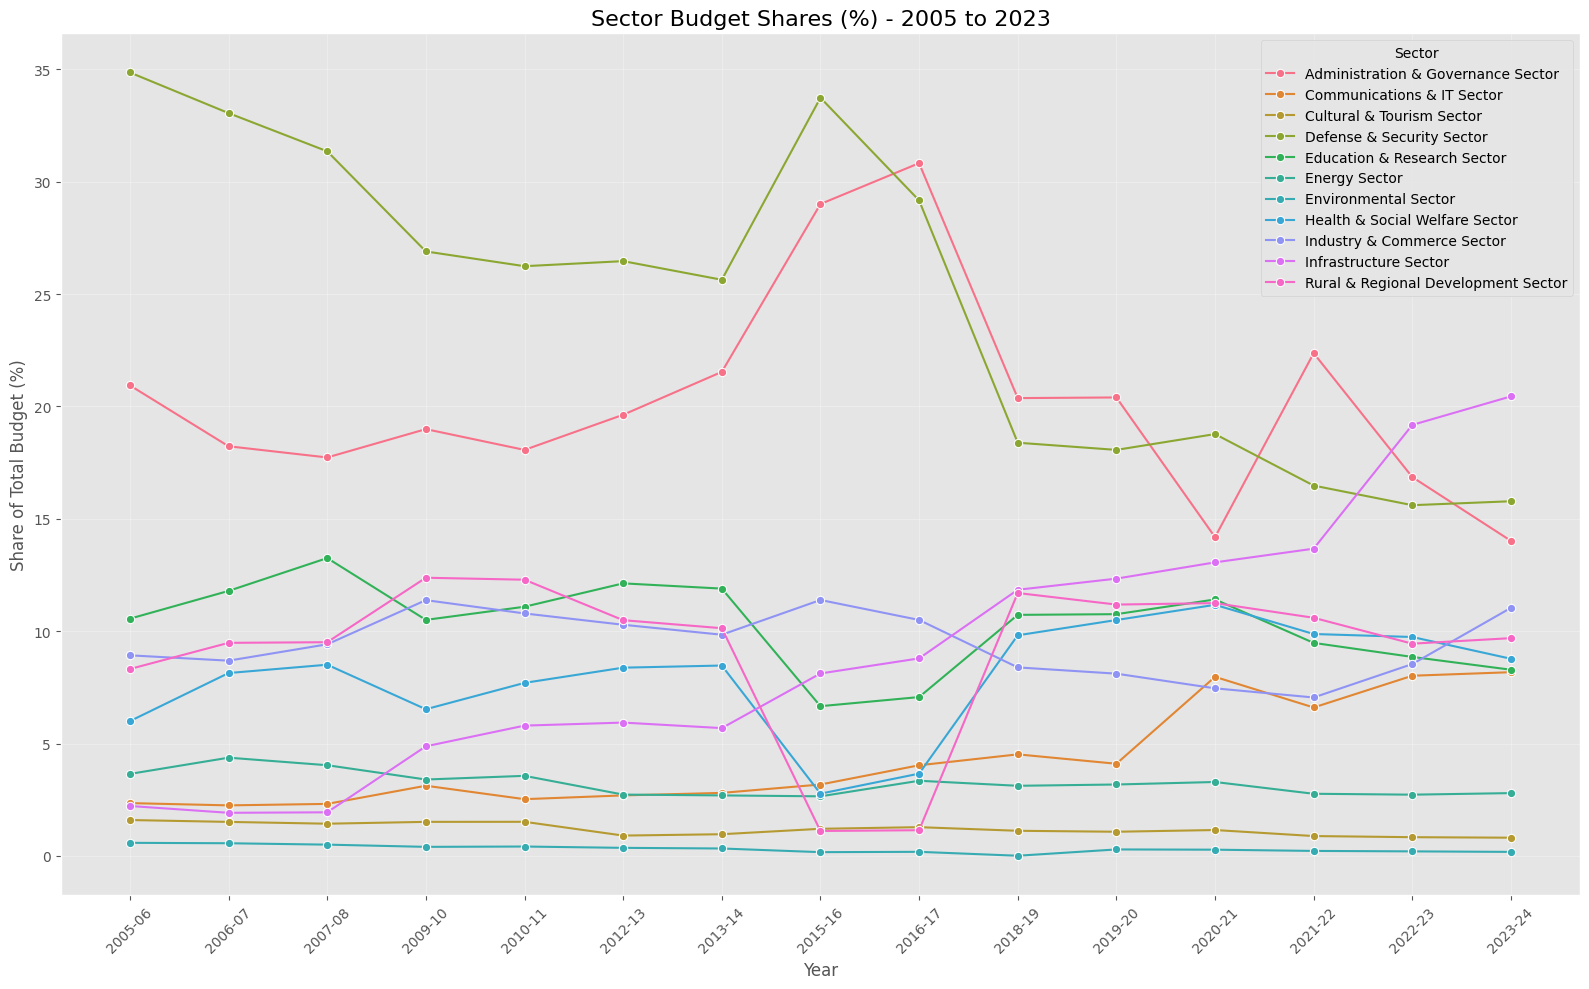

In [23]:
%pip install rapidfuzz
import pandas as pd
import numpy as np
from rapidfuzz import fuzz
import matplotlib.pyplot as plt
import seaborn as sns

# Load your ministry data
df = pd.read_csv('/Users/vvmohith/Desktop/PROJECT/dataset-final/strictly_common_ministries.csv')

# Define comprehensive sector mappings
sector_mapping = {
    "Energy Sector": [
        "atomic energy", "coal", "power", "mines", 
        "petroleum and natural gas", "new and renewable energy"
    ],
    
    "Infrastructure Sector": [
        "civil aviation", "housing and urban affairs", "road transport and highways",
        "shipping", "railways", "urban development", "water resources"
    ],
    
    "Communications & IT Sector": [
        "electronics and information technology", "posts", "telecommunications", 
        "information technology"
    ],
    
    "Industry & Commerce Sector": [
        "commerce", "corporate affairs", "fertilisers", "food processing industries", 
        "steel", "textiles", "public enterprises", "chemicals and petrochemicals",
        "pharmaceuticals", "heavy industry", "micro small and medium enterprises"
    ],
    
    "Health & Social Welfare Sector": [
        "health and family welfare", "social justice and empowerment", 
        "tribal affairs", "women and child development", "labour and employment",
        "ayush", "minority affairs", "social welfare"
    ],
    
    "Education & Research Sector": [
        "higher education", "school education and literacy", "biotechnology", 
        "science and technology", "scientific and industrial research", "space",
        "education", "skill development and entrepreneurship"
    ],
    
    "Cultural & Tourism Sector": [
        "culture", "tourism", "information and broadcasting", "youth affairs and sports",
        "art and culture"
    ],
    
    "Administration & Governance Sector": [
        "consumer affairs", "external affairs", "food and public distribution", 
        "home affairs", "law and justice", "planning", "statistics and programme implementation",
        "personnel public grievances and pensions", "parliamentary affairs"
    ],
    
    "Rural & Regional Development Sector": [
        "rural development", "development of north eastern region", "land resources",
        "panchayati raj", "agricultural research and education"
    ],
    
    "Environmental Sector": [
        "environment forests and climate change", "environment and forests"
    ],
    
    "Defense & Security Sector": [
        "defence services", "defence civil"
    ]
}

# Create a reverse mapping for easy lookup
ministry_to_sector = {}
for sector, ministries in sector_mapping.items():
    for ministry in ministries:
        ministry_to_sector[ministry] = sector

# Function to assign sector using exact match or fuzzy matching as fallback
def assign_sector(ministry_name, threshold=75):
    # Check for direct match
    if ministry_name in ministry_to_sector:
        return ministry_to_sector[ministry_name]
    
    # If no direct match, try fuzzy matching
    best_match = None
    best_score = 0
    
    for known_ministry in ministry_to_sector.keys():
        score = fuzz.ratio(ministry_name.lower(), known_ministry.lower())
        if score > best_score and score >= threshold:
            best_score = score
            best_match = known_ministry
    
    if best_match:
        print(f"Fuzzy matched '{ministry_name}' to '{best_match}' (score: {best_score})")
        return ministry_to_sector[best_match]
    else:
        # No good match found, try partial matching with sector keywords
        for sector, keywords in sector_mapping.items():
            for keyword in keywords:
                if keyword in ministry_name or ministry_name in keyword:
                    print(f"Keyword matched '{ministry_name}' to '{sector}' via '{keyword}'")
                    return sector
        
        return "Other"

# Apply sector assignment
df['Sector'] = df['Ministry'].apply(assign_sector)

# Create a year mapping for clean display
year_mapping = {}
budget_cols = [col for col in df.columns if col.startswith('Budget_')]
for col in budget_cols:
    year_str = col.replace('Budget_', '')
    # Convert '05-06' to '2005-06'
    if len(year_str) == 5:  # Format: '05-06'
        year_fiscal = '20' + year_str
        year_mapping[col] = year_fiscal

# Create clean year columns for analysis
for old_col, new_year in year_mapping.items():
    df[new_year] = df[old_col]

# Get list of year columns properly (this is the fix for the KeyError)
year_columns = list(year_mapping.values())

# Calculate sector-wise total budgets
sector_budget_df = df.groupby('Sector')[year_columns].sum().reset_index()

# Calculate total budget for each year
total_budget_by_year = {}
for col in year_columns:
    total_budget_by_year[col] = df[col].sum()

# Calculate sector shares as percentage
sector_share_df = pd.DataFrame({'Sector': sector_budget_df['Sector']})
for year_col in year_columns:
    sector_share_df[f'{year_col}_share'] = sector_budget_df[year_col] / total_budget_by_year[year_col] * 100

# Calculate year-over-year growth rates
sector_growth_df = pd.DataFrame({'Sector': sector_budget_df['Sector']})
years_list = sorted(year_columns)

for i in range(1, len(years_list)):
    prev_year = years_list[i-1]
    curr_year = years_list[i]
    growth_col = f'Growth_{prev_year}_to_{curr_year}'
    
    # Calculate growth rate
    sector_growth_df[growth_col] = ((sector_budget_df[curr_year] / sector_budget_df[prev_year]) - 1) * 100

# Save the processed data
df.to_csv('/Users/vvmohith/Desktop/PROJECT/dataset-final/ministry_with_sectors.csv', index=False)
sector_budget_df.to_csv('/Users/vvmohith/Desktop/PROJECT/dataset-final/sector_budget_totals.csv', index=False)
sector_share_df.to_csv('/Users/vvmohith/Desktop/PROJECT/dataset-final/sector_budget_shares.csv', index=False)
sector_growth_df.to_csv('/Users/vvmohith/Desktop/PROJECT/dataset-final/sector_growth_rates.csv', index=False)

print("Processing complete. Created the following files:")
print("1. ministry_with_sectors.csv - Original ministry data with sector assignments")
print("2. sector_budget_totals.csv - Total budget by sector and year")
print("3. sector_budget_shares.csv - Percentage share of total budget by sector and year")
print("4. sector_growth_rates.csv - Year-over-year growth rates by sector")

# Create a visualization of sector budget shares over time
plt.figure(figsize=(16, 10))
sector_shares_long = pd.melt(
    sector_share_df, 
    id_vars=['Sector'], 
    value_vars=[col for col in sector_share_df.columns if '_share' in col],
    var_name='Year',
    value_name='Share'
)
sector_shares_long['Year'] = sector_shares_long['Year'].str.replace('_share', '')

sns.lineplot(data=sector_shares_long, x='Year', y='Share', hue='Sector', marker='o')
plt.title('Sector Budget Shares (%) - 2005 to 2023', fontsize=16)
plt.xticks(rotation=45)
plt.ylabel('Share of Total Budget (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/Users/vvmohith/Desktop/PROJECT/dataset-final/sector_shares_trend.png', dpi=300)
print("5. sector_shares_trend.png - Visualization of sector budget shares over time")

# Optionally add a summary display of sector assignment results
sector_counts = df['Sector'].value_counts()
print("\nSector assignment summary:")
for sector, count in sector_counts.items():
    print(f"{sector}: {count} ministries")

In [25]:
import pandas as pd
import os
import glob
from thefuzz import fuzz, process
import numpy as np
import re

# Base directory
base_dir = "/Users/vvmohith/Desktop/PROJECT/dataset-final"

# Function to normalize ministry names
def normalize_ministry_name(name):
    """Advanced normalization of ministry names"""
    if pd.isna(name):
        return ""
    
    name = str(name).lower()
    
    # Remove numbering prefixes (e.g., "1.", "23.", etc.)
    name = re.sub(r'^\d+\.?\s*', '', name)
    
    # Remove common prefixes
    prefixes = ['ministry of ', 'department of ', 'department for ', 'the ', 'union ']
    for prefix in prefixes:
        if name.startswith(prefix):
            name = name[len(prefix):]
    
    # Standardize common abbreviations
    name = name.replace('&', 'and')
    name = re.sub(r'\(.*?\)', '', name)  # Remove text in parentheses
    name = name.replace("'s", "").replace("'", "")
    name = name.replace('@', '')  # Remove special characters
    
    # Replace common variations
    replacements = {
        "ayurveda, yoga and naturopathy, unani, siddha and homoeopathy": "ayush",
        "chemicals and petro chemicals": "chemicals and petrochemicals",
        "company affairs": "corporate affairs",
        "defence civil estimates": "defence civil",
        "environment and forests": "environment forests and climate change",
        "elementary education and literacy": "school education and literacy",
        "secondary education and higher education": "higher education",
        "industrial policy and promotion": "promotion of industry and internal trade",
        "information technology": "electronics and information technology",
        "urban development": "housing and urban affairs"
    }
    
    for old, new in replacements.items():
        if name == old:
            name = new
    
    # Standardize spaces
    name = re.sub(r'\s+', ' ', name).strip()
    
    return name

# Find all year data folders
def find_year_folders():
    """Find all year folders in the base directory"""
    year_folders = []
    for folder in os.listdir(base_dir):
        if os.path.isdir(os.path.join(base_dir, folder)) and re.match(r'\d{2}-\d{2}', folder):
            year_folders.append(folder)
    return sorted(year_folders)

# Load ministry data for a specific year
def load_ministry_data(year_folder):
    """Load ministry data from a year folder"""
    year_path = os.path.join(base_dir, year_folder)
    
    # Try to find CSV files in the folder
    csv_files = glob.glob(os.path.join(year_path, f"{year_folder}*.csv"))
    if not csv_files:
        print(f"No CSV file found for {year_folder}")
        return None
    
    # Prefer _with_share files if available
    share_files = [f for f in csv_files if '_with_share' in os.path.basename(f)]
    file_path = share_files[0] if share_files else csv_files[0]
    
    try:
        df = pd.read_csv(file_path)
        if len(df.columns) < 2:
            print(f"CSV file {file_path} has insufficient columns")
            return None
        
        # Extract ministry names and budgets
        ministry_col = df.columns[0]
        budget_col = df.columns[1]
        
        # Create a clean dataframe with ministry names, normalized names, and budgets
        ministries_df = pd.DataFrame({
            'Original_Name': df[ministry_col],
            'Normalized_Name': df[ministry_col].apply(normalize_ministry_name),
            'Budget': pd.to_numeric(df[budget_col].astype(str).str.replace(',', ''), errors='coerce')
        })
        
        # Remove non-ministry entries
        exclude_patterns = ['grand total', 'total', 'state plans', 'union territories', 
                           'central ministries', 'finance commission', 'central sector']
        ministries_df = ministries_df[~ministries_df['Normalized_Name'].str.lower().str.contains('|'.join(exclude_patterns), na=False)]
        
        # Drop rows with NaN budget
        ministries_df = ministries_df.dropna(subset=['Budget'])
        
        print(f"Loaded {len(ministries_df)} ministries from {year_folder}")
        return ministries_df
    
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Advanced fuzzy matcher using multiple scoring methods
def advanced_fuzzy_match(source_names, target_names, threshold=70):
    """
    Match source names to target names using multiple fuzzy matching methods
    Returns a dataframe with matches and scores
    """
    matches = []
    
    for source in source_names:
        best_match = None
        best_score = 0
        best_method = None
        
        for target in target_names:
            # Try different matching methods
            ratio = fuzz.ratio(source, target)
            partial_ratio = fuzz.partial_ratio(source, target)
            token_sort = fuzz.token_sort_ratio(source, target)
            token_set = fuzz.token_set_ratio(source, target)
            
            # Use the best score from any method
            methods = [
                ("ratio", ratio),
                ("partial_ratio", partial_ratio),
                ("token_sort", token_sort),
                ("token_set", token_set)
            ]
            
            method, score = max(methods, key=lambda x: x[1])
            
            if score > best_score:
                best_score = score
                best_match = target
                best_method = method
        
        # If we found a match above the threshold, record it
        if best_score >= threshold:
            matches.append({
                'Source_Name': source,
                'Target_Name': best_match,
                'Match_Score': best_score,
                'Match_Method': best_method
            })
        else:
            # No good match found
            matches.append({
                'Source_Name': source,
                'Target_Name': None,
                'Match_Score': 0,
                'Match_Method': None
            })
    
    return pd.DataFrame(matches)

# Main matching function
def create_advanced_matches(start_year, end_year, threshold=75):
    """
    Create matches between ministries from start_year and end_year
    using advanced fuzzy matching techniques
    """
    # Load ministry data
    start_data = load_ministry_data(start_year)
    end_data = load_ministry_data(end_year)
    
    if start_data is None or end_data is None:
        print("Could not load data for one or both years")
        return
    
    print(f"\nMatching ministries from {start_year} to {end_year}...")
    
    # Get unique normalized names
    start_names = start_data['Normalized_Name'].unique()
    end_names = end_data['Normalized_Name'].unique()
    
    # Perform advanced matching
    matches = advanced_fuzzy_match(start_names, end_names, threshold)
    
    # Create a mapping to original names
    start_name_map = dict(zip(start_data['Normalized_Name'], start_data['Original_Name']))
    end_name_map = dict(zip(end_data['Normalized_Name'], end_data['Original_Name']))
    
    # Add original names to the matches
    matches['Ministry_' + start_year.replace('-', '_')] = matches['Source_Name'].map(start_name_map)
    matches['Matched_Ministry_' + end_year.replace('-', '_')] = matches['Target_Name'].map(end_name_map)
    
    # Rearrange columns
    result = matches[[f'Ministry_{start_year.replace("-", "_")}', 
                     f'Matched_Ministry_{end_year.replace("-", "_")}', 
                     'Match_Score', 'Match_Method']]
    
    # Sort by match score descending
    result = result.sort_values('Match_Score', ascending=False)
    
    # Save to CSV
    output_path = os.path.join(base_dir, f"advanced_matched_ministries_{start_year}_to_{end_year}.csv")
    result.to_csv(output_path, index=False)
    
    print(f"Saved matches to {output_path}")
    print(f"Found {len(result[result['Match_Score'] >= threshold])} matches with score >= {threshold}")
    
    return result

# Create matches between 05-06 and all other years
def create_all_matches():
    """Create matches between 05-06 and all other years"""
    base_year = "05-06"
    all_years = find_year_folders()
    
    # Remove base year from list of target years
    target_years = [year for year in all_years if year != base_year]
    
    all_results = {}
    for year in target_years:
        print(f"\n{'='*50}")
        print(f"Matching {base_year} to {year}")
        print(f"{'='*50}")
        result = create_advanced_matches(base_year, year, threshold=70)
        if result is not None:
            all_results[year] = result
    
    return all_results

# Run the advanced matching
all_matches = create_all_matches()

# Create a comprehensive time-series mapping
def create_comprehensive_mapping():
    """
    Create a comprehensive mapping that tracks ministries across all years
    """
    base_year = "05-06"
    all_years = find_year_folders()
    
    # Load base year data
    base_data = load_ministry_data(base_year)
    if base_data is None:
        return
    
    # Start with base year ministries
    comprehensive = pd.DataFrame({
        'Base_Ministry': base_data['Original_Name'],
        'Normalized_Name': base_data['Normalized_Name'],
        base_year: base_data['Budget']
    })
    
    # Add matches for each target year
    for year in [y for y in all_years if y != base_year]:
        # Load the matches for this year
        match_file = os.path.join(base_dir, f"advanced_matched_ministries_{base_year}_to_{year}.csv")
        if not os.path.exists(match_file):
            print(f"Match file for {year} not found, skipping")
            continue
            
        matches = pd.read_csv(match_file)
        
        # Load the target year data
        year_data = load_ministry_data(year)
        if year_data is None:
            continue
            
        # Create mapping from matched ministry to budget
        target_budgets = dict(zip(year_data['Original_Name'], year_data['Budget']))
        
        # Map source ministry to target ministry
        ministry_map = dict(zip(matches[f'Ministry_{base_year.replace("-", "_")}'], 
                               matches[f'Matched_Ministry_{year.replace("-", "_")}']))
        
        # Add target year's budget based on the mapping
        comprehensive[year] = comprehensive['Base_Ministry'].map(ministry_map).map(target_budgets)
    
    # Clean up the output
    result = comprehensive.drop('Normalized_Name', axis=1)
    
    # Save comprehensive mapping
    output_path = os.path.join(base_dir, "comprehensive_ministry_mapping.csv")
    result.to_csv(output_path, index=False)
    print(f"\nSaved comprehensive mapping to {output_path}")
    
    # Also save a version with only ministries present in all years
    complete_rows = result.dropna(how='any')
    complete_output = os.path.join(base_dir, "complete_ministry_mapping.csv")
    complete_rows.to_csv(complete_output, index=False)
    print(f"Saved mapping with only complete data to {complete_output}")
    print(f"Found {len(complete_rows)} ministries with data for all years")
    
    return result

# Create comprehensive mapping
comprehensive_mapping = create_comprehensive_mapping()


Matching 05-06 to 06-07
Loaded 90 ministries from 05-06
Loaded 92 ministries from 06-07

Matching ministries from 05-06 to 06-07...
Saved matches to /Users/vvmohith/Desktop/PROJECT/dataset-final/advanced_matched_ministries_05-06_to_06-07.csv
Found 84 matches with score >= 70

Matching 05-06 to 07-08
Loaded 90 ministries from 05-06
Loaded 106 ministries from 07-08

Matching ministries from 05-06 to 07-08...
Saved matches to /Users/vvmohith/Desktop/PROJECT/dataset-final/advanced_matched_ministries_05-06_to_07-08.csv
Found 81 matches with score >= 70

Matching 05-06 to 09-10
Loaded 90 ministries from 05-06
Loaded 91 ministries from 09-10

Matching ministries from 05-06 to 09-10...
Saved matches to /Users/vvmohith/Desktop/PROJECT/dataset-final/advanced_matched_ministries_05-06_to_09-10.csv
Found 85 matches with score >= 70

Matching 05-06 to 10-11
Loaded 90 ministries from 05-06
Loaded 76 ministries from 10-11

Matching ministries from 05-06 to 10-11...
Saved matches to /Users/vvmohith/De

In [29]:
# Example code structure for ministry standardization
import pandas as pd

# Load your mapping file
ministry_mapping = pd.read_csv("advanced_matched_ministries_05-06_to_15-16.csv")

# Create standard ministry list (use the most recent naming convention)
standard_ministries = set(ministry_mapping['Matched_Ministry_15_16'].unique())

# Process each year's budget file to standardized names
all_years_data = []
for year in range(5, 24):  # 05-06 to 22-23
    year_str = f"{year:02d}-{(year+1):02d}"
    file_path = f"/Users/vvmohith/Desktop/PROJECT/dataset-final/{year_str}/{year_str}.csv"
    
    if os.path.exists(file_path):
        # Your existing code to load and map ministries
        # Use the mapping to standardize ministry names
        year_df = pd.DataFrame({
            'Year': year_str,
            'Ministry': standardized_ministry_names,
            'Budget': budget_values
        })
        all_years_data.append(year_df)

# Combine into one master dataset
master_budget_df = pd.concat(all_years_data)
master_budget_df.to_csv("standardized_budget_dataset.csv", index=False)

FileNotFoundError: [Errno 2] No such file or directory: 'advanced_matched_ministries_05-06_to_15-16.csv'